In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
import os
import json
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
from alplakes import parse_alplakes_3d_timeserie_from_directory, get_3d_profile_from_api, open_json, parse_json_3d_profile_to_df, parse_alplakes_1d_from_directory
from utils import save_json

### Parameters

In [3]:
lake_name = "geneva"
sta_name = 'geneva_lexplore'

model = 'geneva_200m_secchi-half'

In [4]:
var_to_plot = 'THETA'

## Import cropped netcdf MITgcm results

In [5]:
label_dalton = 'MITgcm cdalton=0.063'
ds_dalton = xr.open_dataset(r"D:\geneva_200m_dalton\cropped_results_nc\lexplore_depth_time_cdalton063.nc")

In [6]:
label_secchi = 'MITgcm Secchi/2'
ds_secchi = xr.open_dataset(r"D:\geneva_200m_secchi_half\cropped_results_nc\lexplore_depth_time.nc")

In [7]:
label_mitgcm = 'MITgcm'
ds_mitgcm = xr.open_dataset(r"D:\new_geneva_200m\cropped_results_nc\lexplore_temp_depth_time.nc")

## Import measure

In [8]:
start_date = pd.to_datetime(ds_dalton['time'].values[0]).to_pydatetime()  #datetime(2024, 1, 1, 0, 0, 0)
end_date = pd.to_datetime(ds_dalton['time'].values[-1]).to_pydatetime() #datetime(2025, 1, 1, 0, 0, 0)

In [11]:
xr_measure = xr.open_dataset(f'./../../data/datalakes/geneva_idronaut/2024.nc')

## Import 1D simstrat alplakes

In [13]:
# Folder containing the JSON files
folder_path = './../../data/alplakes_1d/geneva/'  # Update this to your specific folder path
simstrat_data = parse_alplakes_1d_from_directory(folder_path)

## Alplakes 3D

In [16]:
def load_alplakes_3d(station_name, depth):
    alplakes_directory = rf"./../../data/alplakes_3d/{station_name}/timeseries_{-depth}m"
    
    if os.path.exists(alplakes_directory):   
        df_alplakes = parse_alplakes_3d_timeserie_from_directory(alplakes_directory)
        
        xr_alplakes = xr.Dataset(
            {
                'temperature': (['time'], df_alplakes['temperature'])
            },
            coords={
                'time': df_alplakes['time']
            }
        )
        
        unique_values, unique_ind = np.unique(xr_alplakes['temperature'].values, return_index=True)
        
        return xr_alplakes.isel(time=np.sort(unique_ind))
    else:
        return None

## Resample timeseries

In [17]:
def interpolate_to_time_axis(xr_ds, time_axis, max_gap):
    interp_result = xr_ds.interp(time=time_axis)
    nearest_times = xr_ds.time.sel(time=time_axis, method="nearest")
    time_diff = abs(nearest_times - time_axis)
    interp_result = interp_result.where(time_diff.values <= max_gap, np.nan)
    
    return interp_result

In [18]:
def resample_all_timeseries(time_step, depth_plot, max_gap_allowed):    
    common_time_axis = pd.date_range(
        start=pd.Timestamp(ds_dalton.time.min().values).normalize(), 
        end=pd.Timestamp(ds_dalton.time.max().values), 
        freq=time_step
    )
    
    meas_selected = xr_measure['temp'].sel(depth=depth_plot, method='nearest') 
    meas_interp = interpolate_to_time_axis(meas_selected, common_time_axis, max_gap_allowed)
    
    dalton_selected=ds_dalton[var_to_plot].sel(Z=depth_plot, method='nearest')
    dalton_interp = interpolate_to_time_axis(dalton_selected, common_time_axis, max_gap_allowed)
    
    secchi_selected=ds_secchi[var_to_plot].sel(Z=depth_plot, method='nearest')
    secchi_interp = interpolate_to_time_axis(secchi_selected, common_time_axis, max_gap_allowed)
    
    mitgcm_selected=ds_mitgcm[var_to_plot].sel(Z=depth_plot, method='nearest')
    mitgcm_interp = interpolate_to_time_axis(mitgcm_selected, common_time_axis, max_gap_allowed)
    
    simstrat_selected = simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date))
    simstrat_interp = interpolate_to_time_axis(simstrat_selected, common_time_axis, max_gap_allowed)
    
    alplakes_selected = load_alplakes_3d(sta_name, depth_plot)['temperature']
    alplakes_interp = interpolate_to_time_axis(alplakes_selected, common_time_axis, max_gap_allowed)
    
    return meas_interp, dalton_interp, secchi_interp, mitgcm_interp, simstrat_interp, alplakes_interp

## Compute RMSE

In [19]:
def compute_rmse(prediction, measures):
    return np.sqrt(np.nanmean((prediction - measures) ** 2))

In [20]:
def compute_rmse_all_timeseries(meas_interp, dalton_interp, secchi_interp, mitgcm_interp, simstrat_interp, alplakes_interp):
    rmse_dalton = compute_rmse(dalton_interp.values, meas_interp.values)
    rmse_secchi = compute_rmse(secchi_interp.values, meas_interp.values)
    rmse_mitgcm = compute_rmse(mitgcm_interp.values, meas_interp.values) 
    rmse_simstrat = compute_rmse(simstrat_interp.values, meas_interp.values) 
    rmse_alplakes = compute_rmse(alplakes_interp.values, meas_interp.values)
    
    return rmse_dalton, rmse_secchi, rmse_mitgcm, rmse_simstrat, rmse_alplakes

## Plot timeserie

In [21]:
time_step = '3h'
depth_plot=-30 # Value should be negative !!
max_gap_allowed = np.timedelta64(3, 'h') 

meas_interp, dalton_interp, secchi_interp, mitgcm_interp, simstrat_interp, alplakes_interp = resample_all_timeseries(time_step, depth_plot, max_gap_allowed)
rmse_dalton, rmse_secchi, rmse_mitgcm, rmse_simstrat, rmse_alplakes = compute_rmse_all_timeseries(meas_interp, dalton_interp, secchi_interp, mitgcm_interp, simstrat_interp, alplakes_interp)

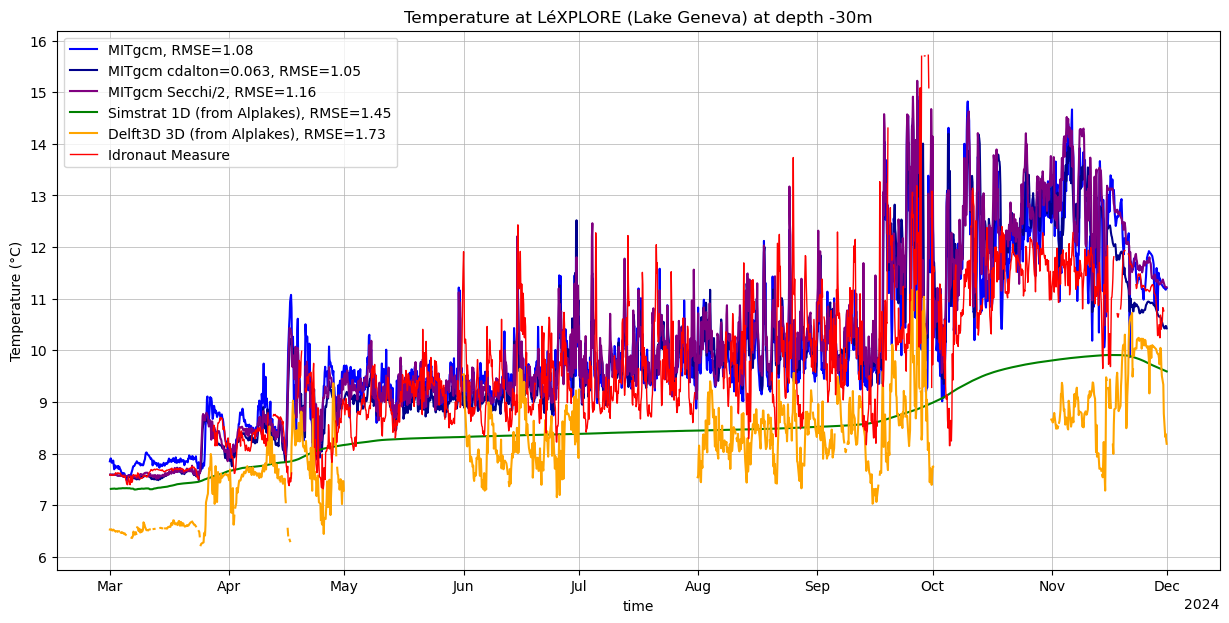

In [24]:
%matplotlib inline
plt.close('all')
fig, ax = plt.subplots(1,1,figsize=(15, 7))

mitgcm_interp.plot(label=f'{label_mitgcm}, RMSE={rmse_mitgcm:.2f}', color='b')
dalton_interp.plot(label=f'{label_dalton}, RMSE={rmse_dalton:.2f}', color='darkblue')
secchi_interp.plot(label=f'{label_secchi}, RMSE={rmse_secchi:.2f}', color='purple')
simstrat_interp.plot(label=f'Simstrat 1D (from Alplakes), RMSE={rmse_simstrat:.2f}', color='g')
alplakes_interp.plot(label=f'Delft3D 3D (from Alplakes), RMSE={rmse_alplakes:.2f}', color='orange')
meas_interp.plot(label=f'Idronaut Measure', color='r', lw=1)

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylabel('Temperature (°C)')
plt.title(f"Temperature at LéXPLORE (Lake Geneva) at depth {depth_plot}m")
plt.show()

#plt.savefig(rf"output_plots\{lake_name}\{model}_{depth_plot}m.png")

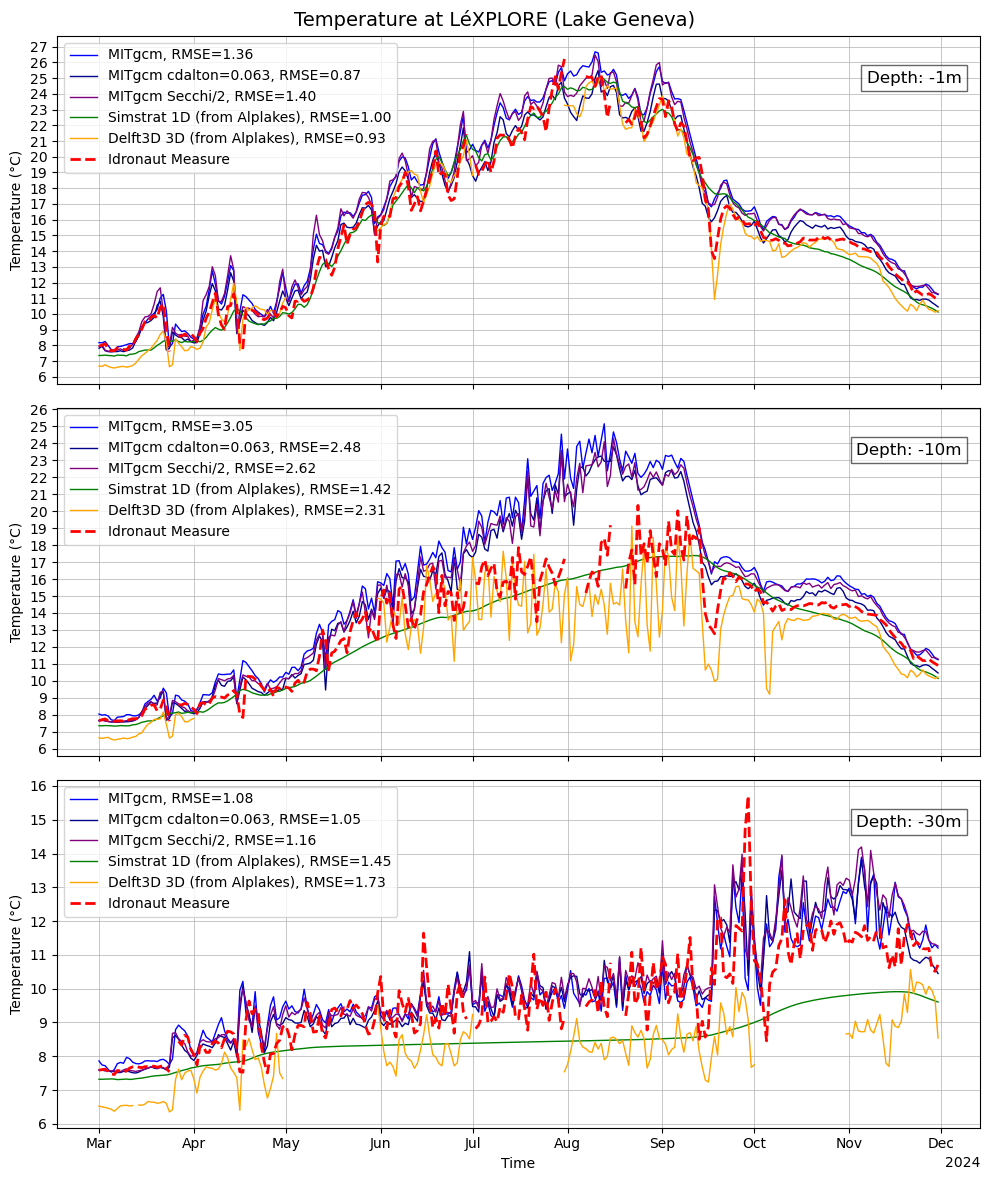

In [35]:
%matplotlib inline
# Flush old figures
plt.close('all')

# Define depths
depths = [-1, -10, -30]

# Create figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
# Loop through subplots and depths
for i, depth_plot in enumerate(depths):
    ax = axes[i]
    
    meas_interp, dalton_interp, secchi_interp, mitgcm_interp, simstrat_interp, alplakes_interp = resample_all_timeseries(time_step, depth_plot, max_gap_allowed)
    rmse_dalton, rmse_secchi, rmse_mitgcm, rmse_simstrat, rmse_alplakes = compute_rmse_all_timeseries(meas_interp, dalton_interp, secchi_interp, mitgcm_interp, simstrat_interp, alplakes_interp)

    # Plot data
    mitgcm_interp.resample(time='d').mean().plot(ax=ax, label=f'{label_mitgcm}, RMSE={rmse_mitgcm:.2f}', color='b', lw=1)
    dalton_interp.resample(time='d').mean().plot(ax=ax, label=f'{label_dalton}, RMSE={rmse_dalton:.2f}', color='darkblue', lw=1)
    secchi_interp.resample(time='d').mean().plot(ax=ax, label=f'{label_secchi}, RMSE={rmse_secchi:.2f}', color='purple', lw=1)
    simstrat_interp.resample(time='d').mean().plot(ax=ax, label=f'Simstrat 1D (from Alplakes), RMSE={rmse_simstrat:.2f}', color='g', lw=1)
    alplakes_interp.resample(time='d').mean().plot(ax=ax, label=f'Delft3D 3D (from Alplakes), RMSE={rmse_alplakes:.2f}', color='orange', lw=1)
    meas_interp.resample(time='d').mean().plot(ax=ax, label=f'Idronaut Measure', color='r', linestyle='dashed', lw=2)

    # Grid, axis formatting
    ax.grid(True, which='both', linestyle='-', linewidth=0.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlabel(None)
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(None)  # Completely remove the title

    # Add depth as a subtitle inside the plot
    ax.text(
        0.98, 0.9, f'Depth: {depth_plot}m', 
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',  # Align text to the right
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='black')
    )
    ax.legend() 

# Global title
fig.suptitle("Temperature at LéXPLORE (Lake Geneva)", fontsize=14)

plt.xlabel("Time")  # Add x-axis label
plt.tight_layout()  # Adjust layout
plt.show()

# Profile

In [40]:
def get_alplakes_profile(date_plot_profil_str):
    with open(os.path.join('./../../config_points.json'), 'r') as file:
        config_points = json.load(file)[sta_name]
    
    lat_station_wgs84 = config_points['lat_station_wgs84']
    long_station_wgs84 = config_points['long_station_wgs84']
    
    alplakes_profile_json_path = rf".\data\alplakes_3d\{sta_name}\profiles\profile_{sta_name}_{date_plot_profil_str}m.json"
    if not os.path.isfile(alplakes_profile_json_path):
        alplakes_profile_json = get_3d_profile_from_api(lake_name, date_plot_profil_str, lat_station_wgs84, long_station_wgs84)
        save_json(alplakes_profile_json, alplakes_profile_json_path)
    else:
        alplakes_profile_json = open_json(alplakes_profile_json_path)
    
    return parse_json_3d_profile_to_df(alplakes_profile_json)

In [47]:
date_plot_profil = datetime(2024,6,1,12,0,0)
date_plot_profil_str = date_plot_profil.strftime('%Y%m%d%H%M')

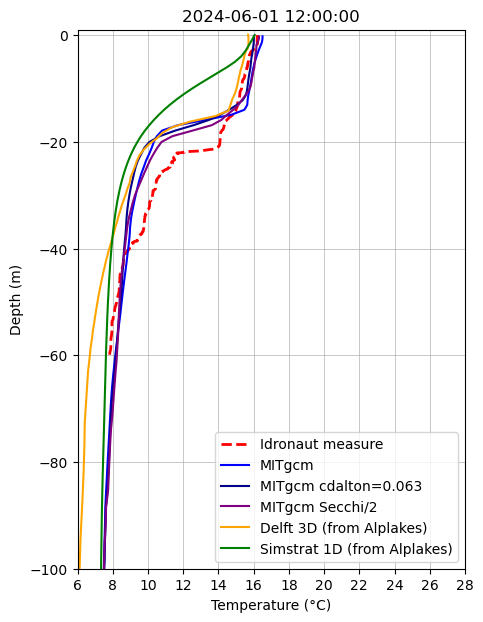

In [48]:
%matplotlib inline
plt.close()
fig, ax = plt.subplots(1,1,figsize=(5, 7))

meas_profile = xr_measure['temp'].sel(time=date_plot_profil, method='nearest')
plt.plot(meas_profile.values, meas_profile.depth.values, label=f'Idronaut measure', color='r', linestyle='--', linewidth=2)

profile_mitgcm = ds_mitgcm[var_to_plot].sel(time=date_plot_profil, method='nearest')
profile_mitgcm.where(profile_mitgcm != 0, np.nan).plot(y='Z', label=f'{label_mitgcm}', color='b')

profile_dalton = ds_dalton[var_to_plot].sel(time=date_plot_profil, method='nearest')
profile_dalton.where(profile_dalton != 0, np.nan).plot(y='Z', label=f'{label_dalton}', color='darkblue')

profile_secchi = ds_secchi[var_to_plot].sel(time=date_plot_profil, method='nearest')
profile_secchi.where(profile_secchi != 0, np.nan).plot(y='Z', label=f'{label_secchi}', color='purple')

alplakes_profile = get_alplakes_profile(date_plot_profil_str)
plt.plot(alplakes_profile['temperature'],-1*alplakes_profile['depth'], label=f'Delft 3D (from Alplakes)', color='orange')

# Convert Simstrat depth to negative and plot
simstrat_depth_negative = -simstrat_data['depth'].values  # Convert to negative NumPy array
simstrat_temperature = simstrat_data['temperature'].sel(time=date_plot_profil, method='nearest')
plt.plot(simstrat_temperature.values, simstrat_depth_negative, label='Simstrat 1D (from Alplakes)', color='g')

plt.title(f"{date_plot_profil}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.ylim(bottom=-100, top=1)
plt.xlim(left=6, right=28)
plt.xlabel('Temperature (°C)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.legend()
plt.show()
# plt.savefig(rf"output_plots\{lake_name}\profile_{date_plot_profil.date()}.png")